In [1]:
pip install spektral

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch===1.3.1 torchvision===0.4.2 -f https://download.pytorch.org/whl/torch_stable.html #install pytorch


Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [5]:
from matplotlib import colors
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
from geopandas.tools import sjoin
import shapely
from shapely.geometry import Point
import pyreadr
import mercantile
from shapely.geometry import shape
import networkx as nx
import seaborn as sns
import pickle
import scipy.sparse as sp
from scipy.optimize import least_squares
import datetime
import lmfit
from sklearn import metrics
from scipy.integrate import odeint

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as Fun


from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

import tensorflow as tf

import sklearn
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

import os

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

import scipy

from sklearn.model_selection import train_test_split

import spektral

# Import Data and Pre-processing

Socio economic Data:


https://appsso.eurostat.ec.europa.eu/nui/setupDownloads.do 


In [6]:
###############
# Import data #
###############

root_data = '/Users/ignaciosacristanbarba/Documents/M4R/Data'
root_results =  '/Users/ignaciosacristanbarba/Documents/M4R/Results'
root_figures =  '/Users/ignaciosacristanbarba/Documents/M4R/Figures'

### import socio economic data and create a dataframe with all of them

# population density
root1 = root_data + '/NUTS3_socioeconomic'+'/pop_density.xlsx'
popdensity_df = pd.read_excel(root1)
popdensity_df.rename(columns={'2018':'pop_density'}, inplace=True)
popdensity_df.rename(columns={'GEO': 'nuts'}, inplace=True)
popdensity_df.drop(['GEO(L)/TIME'],axis = 1,inplace = True)

# gdp
root1 = root_data + '/NUTS3_socioeconomic'+'/gdp.xlsx'
gdp_df = pd.read_excel(root1)
gdp_df.rename(columns={'2018':'gdp'}, inplace=True)
gdp_df.rename(columns={'GEO': 'nuts'}, inplace=True)
gdp_df.drop(['GEO(L)/TIME'],axis = 1,inplace = True)


# emplyoment
root1 = root_data + '/NUTS3_socioeconomic'+'/employment.xlsx'
employment_df = pd.read_excel(root1)
employment_df.rename(columns={'2018':'employment'}, inplace=True)
employment_df.rename(columns={'GEO': 'nuts'}, inplace=True)
employment_df.drop(['GEO(L)/TIME'],axis = 1,inplace = True)


# population + unemployment + unemployment rate
root1 = root_data + '/NUTS3_socioeconomic'+'/pop+labour_data.xlsx'
pop_labour_df = pd.read_excel(root1)
pop_labour_df.rename(columns = {'Unnamed: 0':'nuts','Unnamed: 1':'name','Population1':'population',
                                'Unemployment3':'unemployment','Unnamed: 4':'unemployment_rate'},inplace = True)
pop_labour_df.drop(['Unnamed: 5'],axis = 1,inplace = True)
pop_labour_df.dropna(axis=0,inplace = True)

# merge all features 
socio_economic_df = pd.merge(popdensity_df, gdp_df, how = 'inner',on = 'nuts')
socio_economic_df = pd.merge(socio_economic_df, employment_df, how = 'inner',on = 'nuts')
socio_economic_df = pd.merge(socio_economic_df, pop_labour_df, how = 'inner',on = 'nuts')
socio_economic_df.drop(['name'],axis = 1,inplace = True)
socio_economic_df = socio_economic_df.drop(socio_economic_df[socio_economic_df.unemployment.str.contains('[#~]')
                 | socio_economic_df.unemployment.str.contains('[#~]')].index)

# reset index
socio_economic_df = socio_economic_df.reset_index(drop = True)

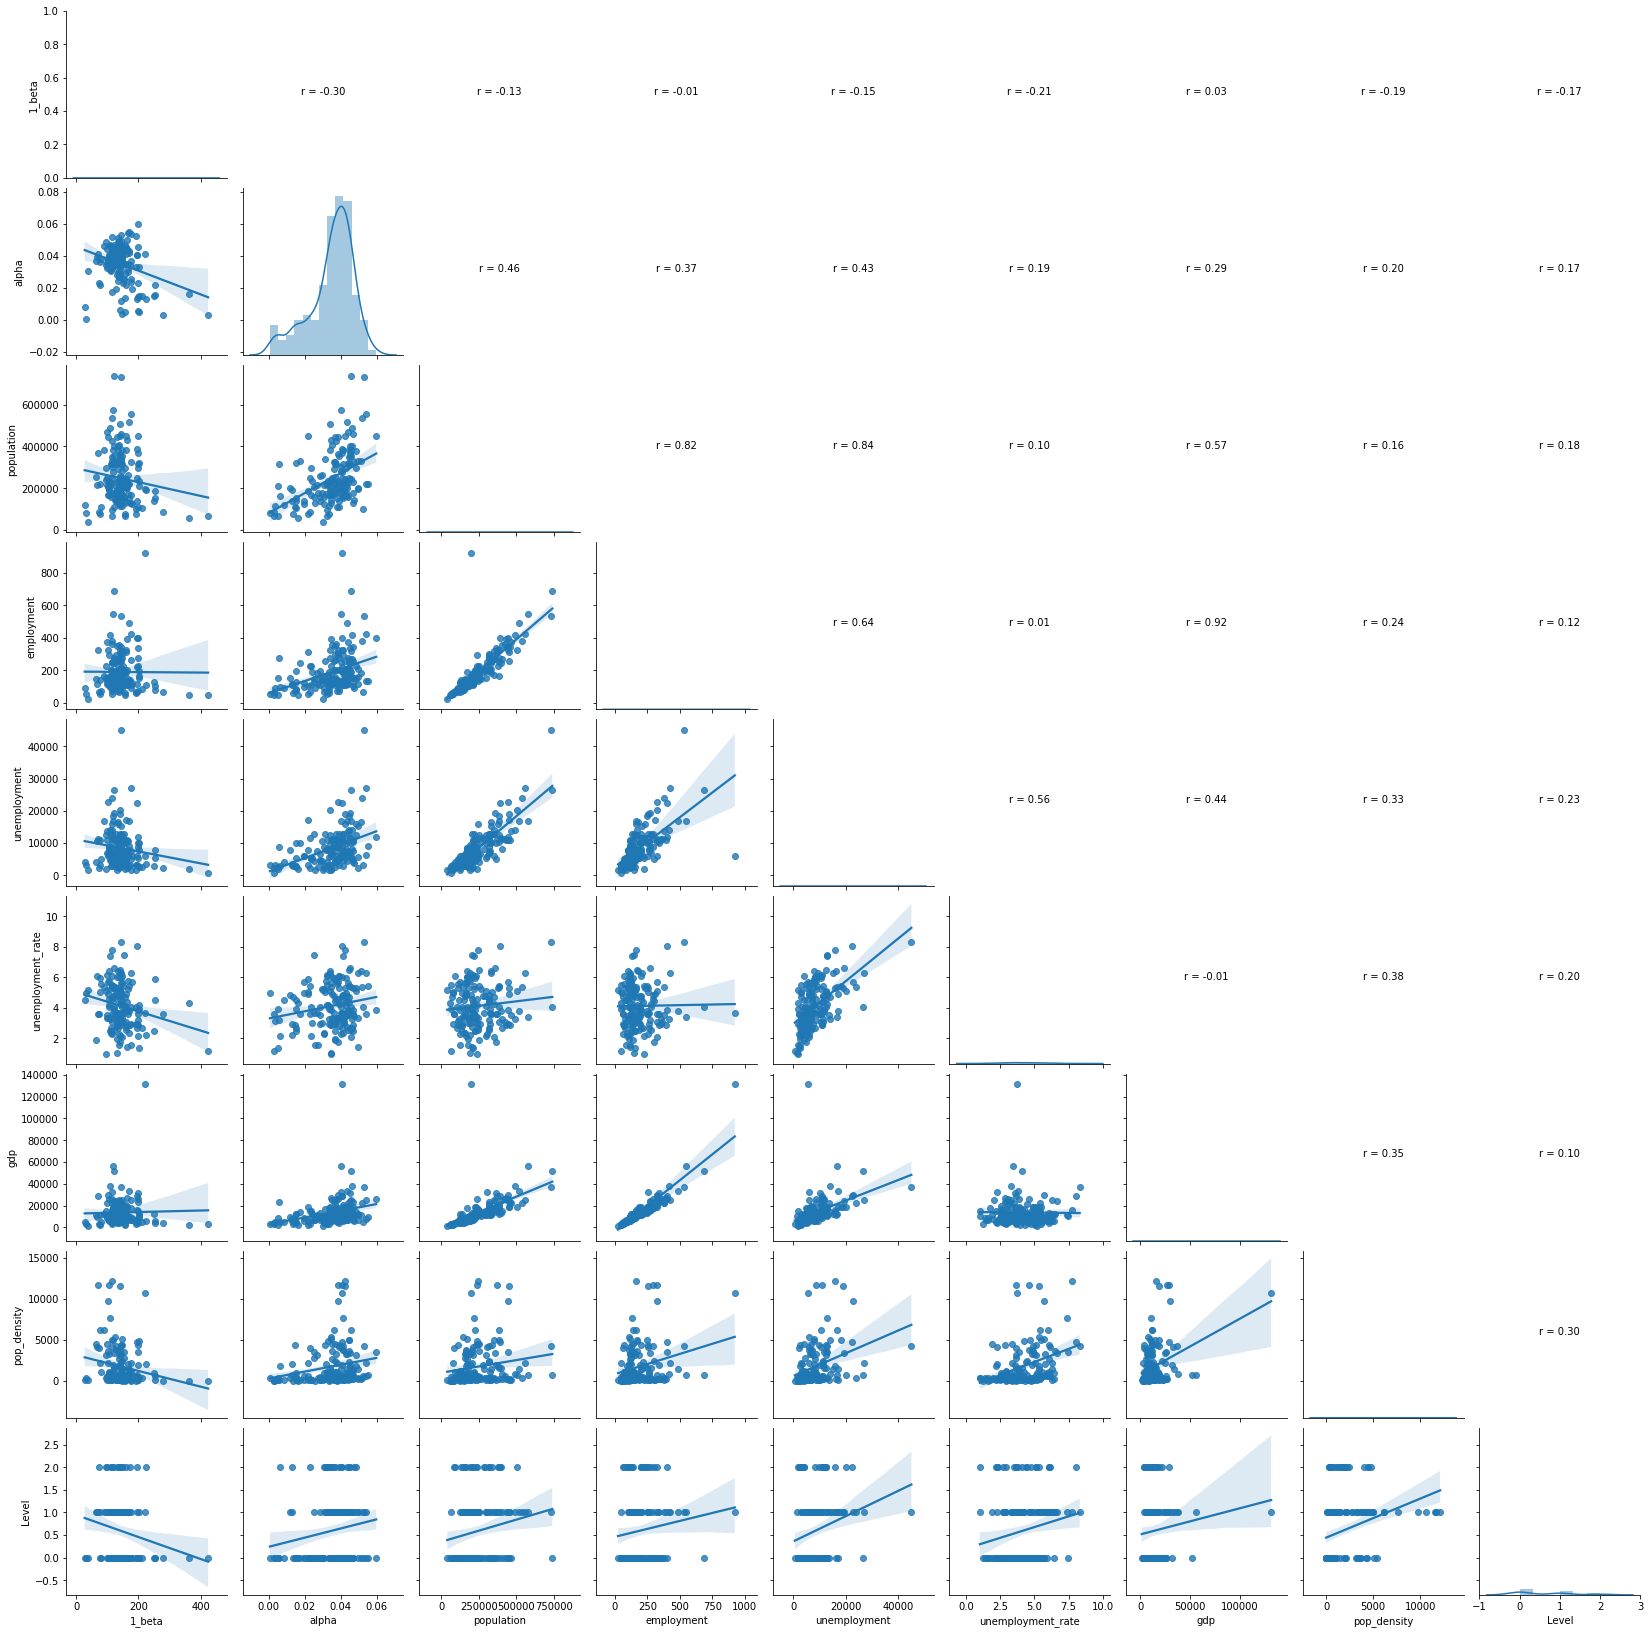

In [7]:
# import NUTS3 dictionary of regions numbers
root5 = root_results + '/NUTS3_graph' + '/NUTS3_dict_no.pkl'
with open(root5, 'rb') as handle:
    NUTS3_dict_no = pickle.load(handle)


# import results of alpha and 1/beta for each NUTS3 region
root5 = root_results + '/NUTS3_graph'+'/gdf_NUTS3_results_in_lscc_asymmetric_try7.csv'
gdf_NUTS3_results_in_lscc = pd.read_csv(root5)

# compute nuts length
socio_economic_df['nuts_len'] = [len(socio_economic_df['nuts'][i]) for i in range(socio_economic_df.shape[0])] 

# merge socio-economic dataframe with geodataframe with parameters results
df_complete = pd.merge(socio_economic_df,gdf_NUTS3_results_in_lscc,how = 'inner',on = 'nuts')

# compute difference in lambdas and compute 1/beta from beta
df_complete['lamba_diff'] = df_complete['lamb2a'] -df_complete['lamb1a']
df_complete['lambb_diff'] = abs(df_complete['lamb2b'] -df_complete['lamb1b'])
df_complete['1_beta'] = 1/df_complete['beta']

# work with positive values of alpha for consistency of models afterwards
df_complete['alpha'] = abs(df_complete['alpha'])

# encode Tier Level
tier_nos = {"Level":  {"Tier1": 0, "Tier2": 1,'Tier3':2}}
df_complete = df_complete.replace(tier_nos)

# function to annotate correlations on pairwise scatterplots
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

# convert all columns to numeric
df_complete[['alpha','population','unemployment','unemployment_rate','gdp','pop_density']] = df_complete[['alpha','population','unemployment','unemployment_rate','gdp','pop_density']].apply(pd.to_numeric)

# plot pairwise scatterplots of alpha and 1/beta vs. socio economic features with annotated correlations
g = sns.PairGrid(df_complete,vars=['1_beta','alpha','population','employment','unemployment','unemployment_rate','gdp','pop_density','Level'])
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)



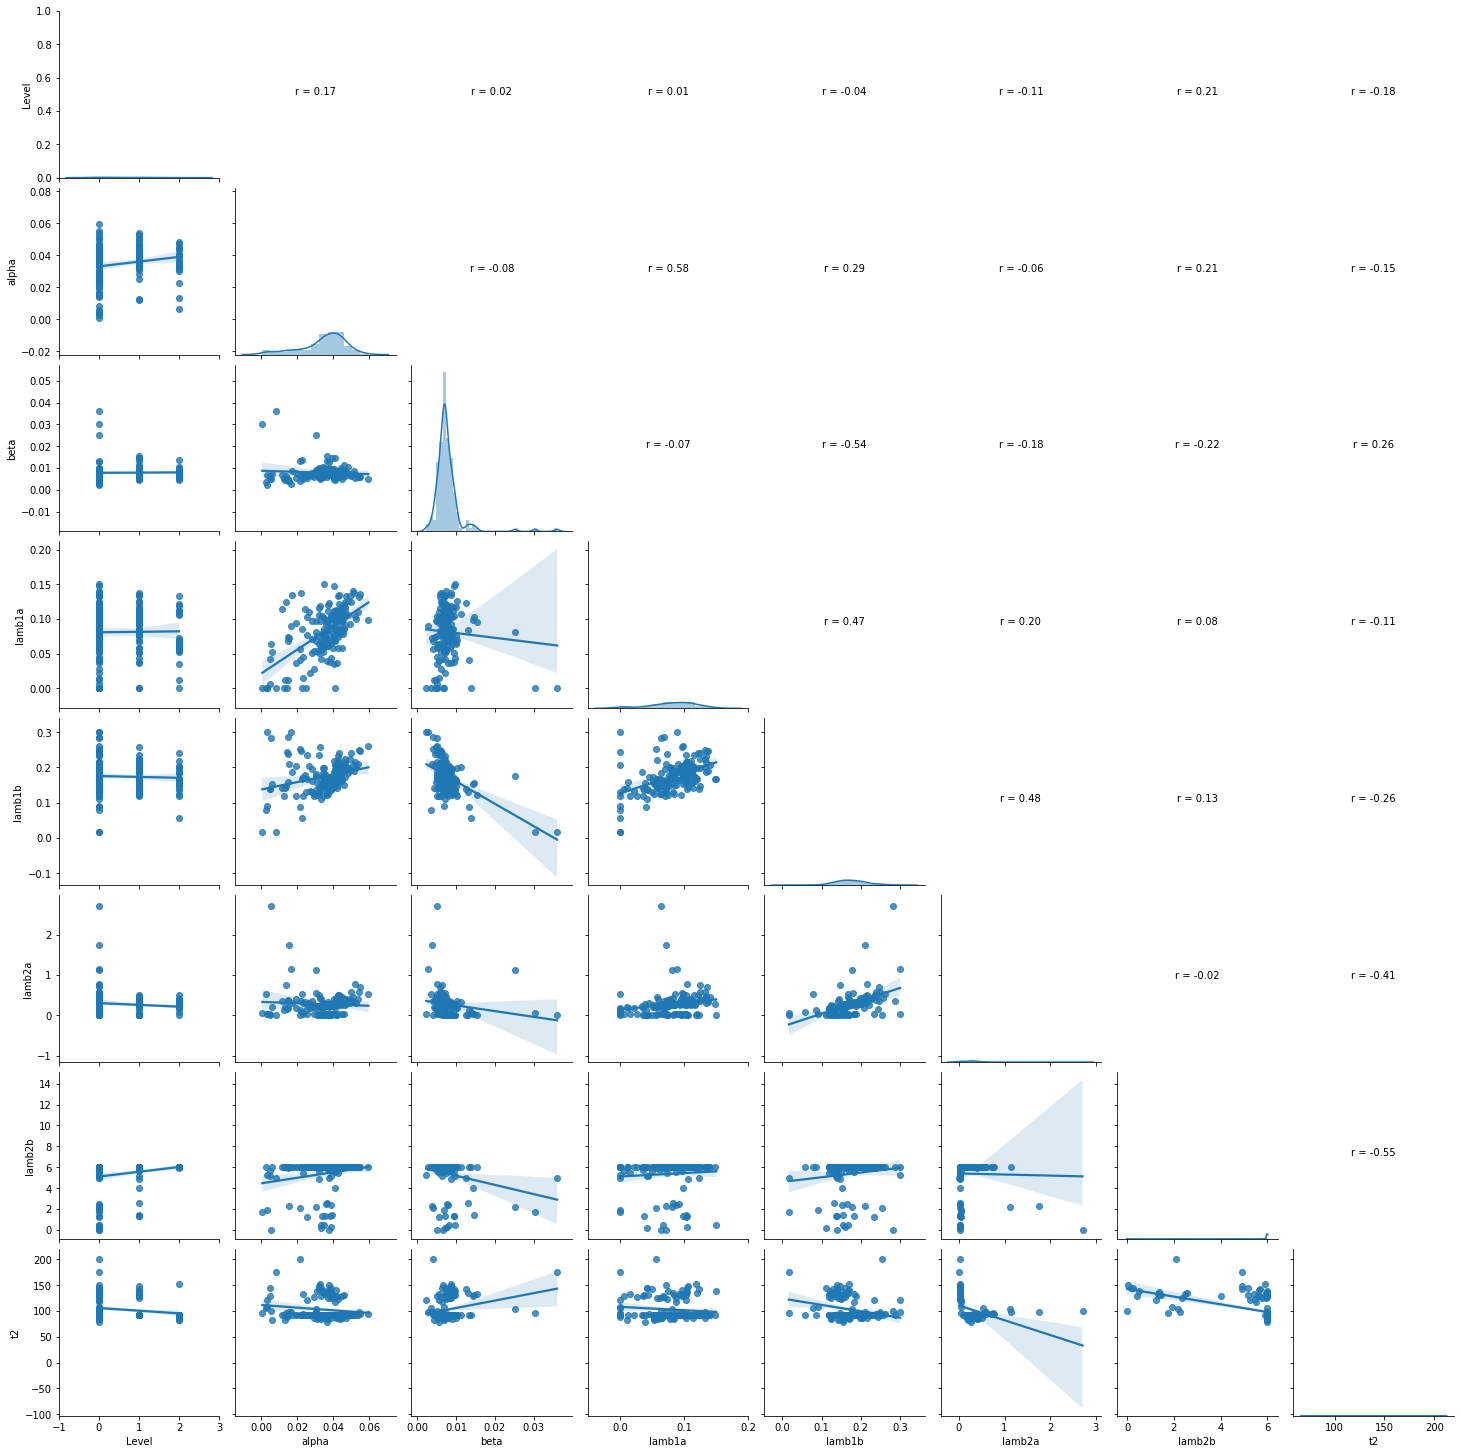

In [8]:
# also plot pairwise scatterplot between other parameters from the model, lambdas, t1, t2, etc.
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()
g = sns.PairGrid(df_complete,vars=['Level','alpha','beta','lamb1a','lamb1b','lamb2a','lamb2b','t2'])
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)

Alpha threshold is 0.03748041630826598
Beta threshold is 139.9114182993444


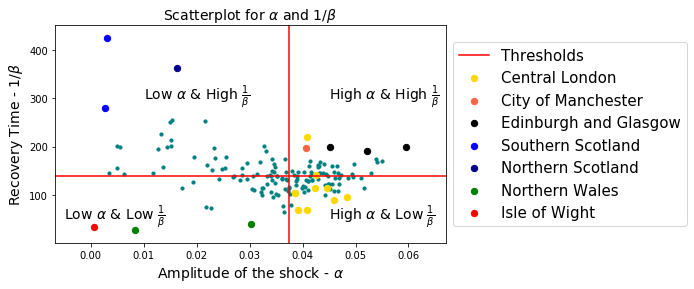

In [9]:
# plot scatterplot between alpha and 1/beta

fig,ax = plt.subplots(1,figsize =(7,4))
ax.scatter(df_complete['alpha'],df_complete['1_beta'],color = 'teal',s = 10)
ax.set_title(r'Scatterplot for $\alpha$ and $1/\beta$',fontsize = 14)
ax.set_xlabel(r'Amplitude of the shock - $\alpha$',fontsize = 14)
ax.set_ylabel(r'Recovery Time - $1/\beta$',fontsize = 14)

# thresholds
alpha_treshold = np.median(df_complete['alpha'])
beta_treshold = np.median(df_complete['1_beta'])

# annotate
ax.annotate(r'High $\alpha$ & Low $\frac{1}{\beta}$',(0.045,50),size=14)
ax.annotate(r'High $\alpha$ & High $\frac{1}{\beta}$',(0.045,300),size = 14)
ax.annotate(r'Low $\alpha$ & High $\frac{1}{\beta}$',(0.01,300),size = 14)
ax.annotate(r'Low $\alpha$ & Low $\frac{1}{\beta}$',(-0.005,50),size = 14)

# annotations = df_complete['nuts']
# for i, txt in enumerate(annotations):
#     #if txt =='UKD33':
#     ax.annotate(txt, (df_complete['alpha'][i], df_complete['1_beta'][i]))

# color certain outlier regions
cdict = {'UKI31': ('gold','Central London'),
         'UKI32': ('gold','Central London'),
         'UKI33': ('gold','Central London'),
         'UKI34': ('gold','Central London'),
         'UKI41': ('gold','Central London'),
         'UKI42': ('gold','Central London'),
         'UKI43': ('gold','Central London'),
         'UKI44': ('gold','Central London'),
         'UKI45': ('gold','Central London'),
         'UKI51': ('gold','Central London'),
         'UKI52': ('gold','Central London'),
         'UKI53': ('gold','Central London'),
         'UKI54': ('gold','Central London'),
         'UKD33': ('tomato','City of Manchester'),
         'UKM75': ('black','Edinburgh and Glasgow'),
         'UKM76': ('black','Edinburgh and Glasgow'),
         'UKM82': ('black','Edinburgh and Glasgow'),
         'UKM92': ('blue','Southern Scotland'), 
         'UKM91': ('blue','Southern Scotland'), 
         'UKM61': ('darkblue','Northern Scotland'),
         'UKL13': ('green','Northern Wales'),
         'UKL11': ('green','Northern Wales'),
         'UKJ34': ('red','Isle of Wight'),
        }     

for i,region in enumerate(list(cdict.keys())):
    ix = df_complete.index[df_complete['nuts']==region].tolist()
    
    ax.scatter(df_complete['alpha'][ix], df_complete['1_beta'][ix],
               color = cdict[region][0], label = cdict[region][1],s = 40)
    
# function so labels are not duplicated in legend
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique),loc='center left',bbox_to_anchor=(1, 0.5),fontsize = 15)

print('Alpha threshold is',alpha_treshold)
print('Beta threshold is',beta_treshold)


ax.axvline(alpha_treshold,ymin = 0,ymax = 800, color='red', linestyle='solid')
ax.axhline(beta_treshold, color='red', linestyle='solid', label='Thresholds')
legend_without_duplicate_labels(ax)

fig.savefig(root_figures + '/Socioeconomic' + '/alphabeta.pdf', bbox_inches='tight')

#### Plot distributions of $\alpha$ and $1/\beta$

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.


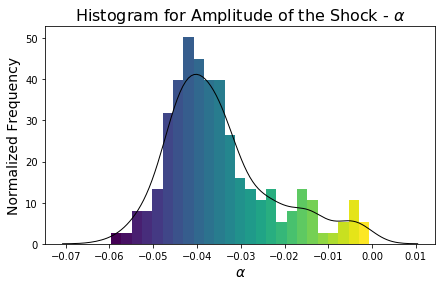

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


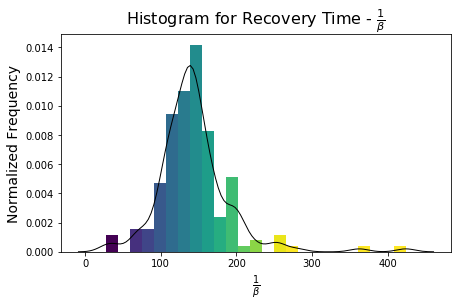

In [10]:
#copy original dataframe
df_complete_c = df_complete.copy()

fig,ax = plt.subplots(1,figsize = (7,4))

# This is  the colormap 
cm = plt.cm.get_cmap('viridis')

# Plot histogram
n, bins, patches = ax.hist(-df_complete['alpha'], 25, normed=1, color='green')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
sns.distplot(-df_complete['alpha'], hist = False, kde = True,
                 kde_kws = {'shade': False, 'linewidth':1},color ='black' )

ax.set_title(r'Histogram for Amplitude of the Shock - $\alpha$',fontsize = 16)
ax.set_xlabel(r'$\alpha$',fontsize = 14)
ax.set_ylabel('Normalized Frequency',fontsize = 14)
plt.show()
fig.savefig(root_figures+'/Socioeconomic'+'/alpha_hist.pdf',dpi=fig.dpi,bbox_inches='tight')


fig,ax = plt.subplots(1,figsize = (7,4))
# colormap 
cm = plt.cm.get_cmap('viridis')

# Plot histogram
n, bins, patches = ax.hist(df_complete['1_beta'], 25, normed=1, color='green')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
max_col = 230 # for better visualization, as in the map
col /= max_col

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
    
sns.distplot(df_complete['1_beta'], hist = False, kde = True,
                 kde_kws = {'shade': False, 'linewidth':1},color ='black' )

ax.set_title(r'Histogram for Recovery Time - $\frac{1}{\beta}$',fontsize = 16)
ax.set_xlabel(r'$\frac{1}{\beta}$',fontsize = 14)
ax.set_ylabel('Normalized Frequency',fontsize = 14)
plt.show()
fig.savefig(root_figures+'/Socioeconomic'+'/1_beta_hist.pdf',dpi=fig.dpi,bbox_inches='tight')

# Clasification Problem 

### Data pre-processing

In [11]:
# call original dataframe and use thresholds to define class response variable
df_complete = df_complete_c.copy()
df_complete['class_response'] = np.zeros(df_complete.shape[0])
df_complete.loc[(df_complete['alpha']<=alpha_treshold) & (df_complete['1_beta']>beta_treshold), 'class_response'] = 0
df_complete.loc[(df_complete['alpha']<=alpha_treshold) & (df_complete['1_beta']<=beta_treshold), 'class_response'] = 1
df_complete.loc[(df_complete['alpha']>alpha_treshold) & (df_complete['1_beta']>beta_treshold), 'class_response'] = 2
df_complete.loc[(df_complete['alpha']>alpha_treshold) & (df_complete['1_beta']<=beta_treshold), 'class_response'] = 3

# definde features to use
features = ['pop_density','gdp','employment','population','unemployment','unemployment_rate']#'Level']

In [12]:
def prepare_train_test(train_index,test_index):
    '''
    Function to prepare data for training and testing,
    given cross-validation indices
    '''

    #create dataframes for train and test data
    train_df = df_complete.iloc[train_index]
    test_df = df_complete.iloc[test_index]


    # Divide by class to resample
    df_0 = train_df[train_df['class_response'] == 0]
    df_1 = train_df[train_df['class_response'] == 1]
    df_2 = train_df[train_df['class_response'] == 2]
    df_3 = train_df[train_df['class_response'] == 3]

    # check how many observations we have of each class
    print(df_0.shape[0], df_1.shape[0], df_2.shape[0], df_3.shape[0])

    max_len = max(df_0.shape[0], df_1.shape[0], df_2.shape[0], df_3.shape[0])
    # resample to achieve the maximum of a given class
    df_0_over = df_0.sample(max_len, replace=True).reset_index().drop(columns=['index'])
    df_1_over = df_1.sample(max_len, replace=True).reset_index().drop(columns=['index'])
    df_2_over = df_2.sample(max_len, replace=True).reset_index().drop(columns=['index'])
    df_3_over = df_3.sample(max_len, replace=True).reset_index().drop(columns=['index'])
    print(len(df_0_over), len(df_1_over), len(df_2_over), len(df_3_over))

    # concatenate the dataframes
    train_df = pd.concat([df_0_over, df_1_over, df_2_over, df_3_over])
    train_df= train_df.reset_index(drop = True)
    
    # define features to use
    features = ['pop_density','gdp','employment','population','unemployment','unemployment_rate']#'Level']
    
    # divide features into train and test
    X_train = train_df[features]
    y_train = train_df['class_response']
    
    # divide response into train and test
    X_test = test_df[features]
    y_test = test_df['class_response']

    # Scaling
    Xc =X_train.copy()
    scaler = StandardScaler()
    #fit scaler
    scaler.fit(Xc)

    #transform train 
    Xc=scaler.transform(Xc)
    X_train=pd.DataFrame(Xc)
    X_train.columns = features

    #transform test
    X_test = scaler.transform(X_test)
    X_test=pd.DataFrame(X_test)
    X_test.columns = features
    
    return X_train,X_test,y_train,y_test

# Keras MLP Classification



28 25 25 28
28 28 28 28
29 25 24 29
29 29 29 29
29 24 25 29
29 29 29 29
2/2 [==============================] - 0s 2ms/step - loss: 3.1196 - accuracy: 0.2593
Fold  0
Training Accuracy =  87.5
Testing Accuracy =  25.925925925925924
2/2 [==============================] - 0s 2ms/step - loss: 2.4690 - accuracy: 0.3585
Fold  1
Training Accuracy =  87.93103448275862
Testing Accuracy =  35.84905660377358
2/2 [==============================] - 0s 2ms/step - loss: 4.2560 - accuracy: 0.2642
Fold  2
Training Accuracy =  88.79310344827587
Testing Accuracy =  26.41509433962264
-------------------------------------------------------------
Average Training Accuracy: 88.0747139453888
Average Testing Accuracy: 29.396691918373108


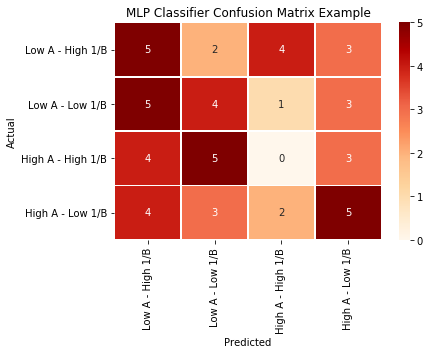

In [13]:
# choose number of folds for cross-validation
N_FOLDS = 3

# define stratified cross-validation splits
skf = StratifiedKFold(n_splits=N_FOLDS,shuffle=True,random_state = 0)

# define features X and response y
X = df_complete[features].values
y = df_complete['class_response']

# get splits
skf.get_n_splits(X, y)

# create empty lists to then insert the folds
X_train_all=[]
X_test_all= []
y_train_all=[]
y_test_all=[]

# loop to insert the data for each fold
for train_index, test_index in skf.split(X, y):### iterate for the N_folds
        
        X_train,X_test,y_train,y_test = prepare_train_test(train_index,test_index)
        X_train_all.append(X_train)
        X_test_all.append(X_test)
        y_train_all.append(y_train)
        y_test_all.append(y_test)
        
# define the MLP model
def build_model():
    # define architecture
    model = Sequential()
    model.add(Dense(100, input_dim=len(features), activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    # compile the keras model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

#sum of accuracies, to then average over N_FOLDS
acc_sum_train = 0
acc_sum_test = 0

# loop for the N_FOLDS
for i in range(N_FOLDS):
    # call model
    model = build_model()
    
    # fit the keras model on the dataset
    history = model.fit(X_train_all[i], y_train_all[i], epochs=50, batch_size=20,verbose =0)
    
    # evaluate the keras model
    _, accuracy_train = model.evaluate(X_train_all[i], y_train_all[i])
    _, accuracy_test = model.evaluate(X_test_all[i], y_test_all[i])
    
    # predict for train and test data to calculate accuracies scores manually, and compute confussion matrix
    y_pred_training = model.predict(X_train_all[i])
    y_pred = model.predict(X_test_all[i])
    
    # transform predictions, which come in the form [p1,p2,p3,p4], where pi are probabilities,
    # into a single output using argmax
    y_pred_c = []
    y_pred_train_c = []
    for j in range(len(y_pred)):
        y_pred_c.append(np.argmax(y_pred[j]))
    for k in range(len(y_pred_training)):
        y_pred_train_c.append(np.argmax(y_pred_training[k]))
    y_pred = y_pred_c
    y_pred_training = y_pred_train_c
    
    
    print('Fold ',i)
    print('Training Accuracy = ',100*accuracy_score(y_train_all[i], y_pred_training))
    print('Testing Accuracy = ',100*accuracy_score(y_test_all[i], y_pred))
    
    # sum accuracies to the total
    acc_sum_train += accuracy_train
    acc_sum_test += accuracy_test

print('-------------------------------------------------------------')
print('Average Training Accuracy:' ,100*(acc_sum_train/N_FOLDS))
print('Average Testing Accuracy:' ,100*(acc_sum_test/N_FOLDS))


# Plot last confussion matrix
mlp_test_confusion_matrix = confusion_matrix(y_test_all[-1],y_pred)
mlp_cm = pd.DataFrame(mlp_test_confusion_matrix, index = ["Low A - High 1/B", "Low A - Low 1/B", "High A - High 1/B",'High A - Low 1/B'],
              columns = ["Low A - High 1/B", "Low A - Low 1/B", "High A - High 1/B",'High A - Low 1/B'])
fig,axs = plt.subplots(ncols=1)
sns.heatmap(mlp_cm, annot=True,cmap="OrRd" ,linewidths=0.5,ax=axs)
axs.set_xlabel('Predicted')
axs.set_ylabel('Actual')
axs.set_title('MLP Classifier Confusion Matrix Example')
fig.savefig(root_figures + '/Socioeconomic'+'/MLP_confusion.pdf',dpi=fig.dpi,bbox_inches='tight')

### MLP with Cross-Validation 

In [14]:
def MLP_base(): 
    '''
    Function to run MLP with cross validation
    '''
    
    # choose number of folds for cross-validation
    N_FOLDS = 3
    skf = StratifiedKFold(n_splits=N_FOLDS,shuffle=True)
    X = df_complete[features].values
    y = df_complete['class_response']
    skf.get_n_splits(X, y)
    #create empty lists to then insert the folds
    X_train_all=[]
    X_test_all= []
    y_train_all=[]
    y_test_all=[]
    
    #loop to insert the data for each loop
    for train_index, test_index in skf.split(X, y):### iterate for the 5 folds

            X_train,X_test,y_train,y_test = prepare_train_test(train_index,test_index)

            X_train_all.append(X_train)
            X_test_all.append(X_test)
            y_train_all.append(y_train)
            y_test_all.append(y_test)
            
    # define the MLP model
    def build_model():
        # define architecture
        model = Sequential()
        model.add(Dense(100, input_dim=len(features), activation='relu'))
        model.add(Dense(100, activation='relu'))
        model.add(Dense(100, activation='relu'))
        model.add(Dense(4, activation='softmax'))
        # compile the keras model
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model
    
    # initialize train and test accuracies
    acc_sum_train = 0
    acc_sum_test = 0
    mlp_test_confusion_matrix = np.zeros((4,4))
    ac_in_MLP = []
    
    for i in range(N_FOLDS):
        
        # call the model
        model = build_model()
        
        # fit the keras model 
        history = model.fit(X_train_all[i], y_train_all[i], epochs=50, batch_size=20,verbose =0)
        
        # evaluate the keras model
        _, accuracy_train = model.evaluate(X_train_all[i], y_train_all[i])
        _, accuracy_test = model.evaluate(X_test_all[i], y_test_all[i])
        
        #predict so that we can compute accuracy manually and confusion matrix
        y_pred_training = model.predict(X_train_all[i])
        y_pred = model.predict(X_test_all[i])
        
        # transform predictions, which come in the form [p1,p2,p3,p4], where pi are probabilities,
        # into a single output using argmax
        y_pred_c = []
        y_pred_train_c = []
        for j in range(len(y_pred)):
            y_pred_c.append(np.argmax(y_pred[j]))
        for k in range(len(y_pred_training)):
            y_pred_train_c.append(np.argmax(y_pred_training[k]))
        y_pred = y_pred_c
        y_pred_training = y_pred_train_c
        
        # report accuracies
        print('Fold ',i)
        print('Training Accuracy = ',100*accuracy_score(y_train_all[i], y_pred_training))
        print('Testing Accuracy = ',100*accuracy_score(y_test_all[i], y_pred))
        
        # store accuracies
        acc_sum_train += accuracy_train
        acc_sum_test += accuracy_test
        
        #store confussion matrix
        mlp_test_confusion_matrix_loop = confusion_matrix(y_test_all[i],y_pred)
        mlp_test_confusion_matrix += mlp_test_confusion_matrix_loop
        
        # append accuracy_test to list of ALL accuracies for later histogram
        ac_in_MLP.append(accuracy_test)
        
    # average over all folds  
    testing_accuracy = 100*(acc_sum_test/N_FOLDS)
    
    # report cross-validation accuracies
    print('-------------------------------------------------------------')
    print('Average Training Accuracy:' ,100*(acc_sum_train/N_FOLDS))
    print('Average Testing Accuracy:' ,testing_accuracy)

    # average confussion matrix
    mlp_test_confusion_matrix /= N_FOLDS

    #return average testing accuracy, confusion matrix, and list with ALL accuracies
    return testing_accuracy,mlp_test_confusion_matrix,ac_in_MLP
    


##### Run 30 times and average to obtain baseline

In [15]:
%%capture
# choose number of runs we want to repeat the process, to account for randomness of the splits
n = 30

# initialize cross-validation accuracy and confussion matrix
total_ac = 0
total_cm = np.zeros((4,4))
# initialize vector with all accuracies of MLP
accs_MLP = []

# run n times
for i in range(n):
    # call the process to run the MLP and record accuracy,
    # confussion matrix, and all accuracies
    ac , cm ,ac_in_MLP = MLP_base()
    accs_MLP.append(ac_in_MLP)
    total_ac += ac
    total_cm += cm

# average over the total number of runs
baseline_ac = total_ac/n
baseline_cm = total_cm/n

In [16]:
# Flatten the list containing lists with all of the un-averaged cross-validation accuracies
# these are useful to report at the end in the histogram of accuracies
accs_MLP = [j for i in accs_MLP for j in i]

# multiply list by 100 to get accuracies
accs_MLP = [100*x for x in accs_MLP]

The BASELINE Accuracy is 30.457333591249252


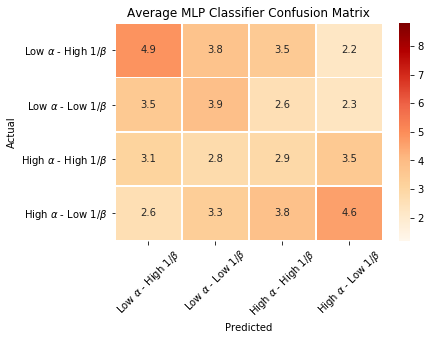

In [17]:
# Report baseline accuracy  
print('The BASELINE Accuracy is',baseline_ac)

# Plot average MLP confussion matrix
mlp_cm = pd.DataFrame(baseline_cm, index = [r"Low $\alpha$ - High 1/$\beta$", r"Low $\alpha$ - Low 1/$\beta$", r"High $\alpha$ - High 1/$\beta$",r'High $\alpha$ - Low 1/$\beta$'],
          
        columns = [r"Low $\alpha$ - High 1/$\beta$",r"Low $\alpha$ - Low 1/$\beta$", r"High $\alpha$ - High 1/$\beta$",r'High $\alpha$ - Low 1/$\beta$'])
fig,axs = plt.subplots(ncols=1)
s = sns.heatmap(mlp_cm, annot=True,cmap="OrRd" ,linewidths=0.5,ax=axs,vmax = 8.8,vmin =1.2)
s.set_xticklabels(s.get_xticklabels(), rotation = 45, fontsize = 10)
axs.set_xlabel('Predicted')
axs.set_ylabel('Actual')
axs.set_title('Average MLP Classifier Confusion Matrix')
fig.savefig(root_figures + '/Socioeconomic'+'/MLP_confusion.pdf',dpi=fig.dpi,bbox_inches='tight')

# Simulating message passing

#### Import Graph and pre-processing

In [18]:
# import graph
root_graph = root_results+'/NUTS3_Graph'+'/NUTS3_base_network_lscc.npz'
with open(root_graph, 'rb') as handle:
        G = pickle.load(handle)

In [19]:
#check which nodes are in df_complete
nodes_in_df = list(df_complete_c['nuts_no'])

G_nodes = list(G.nodes)
print('The graph has',len(G),'nodes')
G_nodes_to_remove = [i for i in G_nodes if i not in nodes_in_df]

# remove those nodes that are not in the dataframe
for i in range(len(G_nodes_to_remove)):
    G.remove_node(G_nodes_to_remove[i])

print('The graph had',len(G),'nodes')

The graph has 175 nodes
The graph had 160 nodes


#### Try with geographic graph

In [20]:
# Import geographic network
root_D_geom = root_results + '/NUTS3_graph/base_D_geom_lscc.pickle'
with open(root_D_geom, 'rb') as handle:
        D_geom = pickle.load(handle)

In [21]:
nuts_lscc = [0, 10, 20, 23, 42, 80, 99, 107, 111, 120, 144, 148, 1, 25, 43, 51, 88, 106, 122, 128, 2, 22, 62,
 71, 76, 89, 136, 178, 3, 31, 33, 35, 115, 162, 166, 4, 5, 12, 17, 18, 24, 28, 50, 68, 72, 74, 87,
 95, 96, 104, 105, 116, 131, 139, 171, 44, 47, 90, 92, 98, 125, 6, 34, 60, 78, 83, 160, 172, 8, 65, 
 126, 149, 151, 169, 9, 102, 110, 173, 13, 86, 124, 170, 11, 37, 100, 127, 168, 30, 137, 153, 174, 55,
 121, 146, 14, 67, 112, 156, 15, 29, 36, 39, 54, 56, 58, 79, 84, 97, 140, 145, 159, 16, 48, 63, 123, 138, 
 141, 27, 75, 19, 40, 167, 176, 21, 41, 113, 114, 32, 152, 154, 161, 165, 26, 52, 117, 38, 59, 81, 82, 129,
 133, 163, 103, 85, 157, 150, 118, 155, 94, 109, 53, 66, 46, 49, 132, 73, 147, 61, 64, 119, 135, 164, 177, 
 175, 134, 70, 77, 108, 93, 130, 142]

print('The LSCC has',len(nuts_lscc),'nodes')
nodes_to_remove = [i for i in nuts_lscc if i not in nodes_in_df]

# remove those nodes that are not in the dataframe
for i in nodes_to_remove:
    D_geom = np.delete(D_geom, i, 0)
    D_geom = np.delete(D_geom, i, 1)

    

print('The graph had',len(G),'nodes')



The LSCC has 171 nodes
The graph had 160 nodes


### Compute adjacency matrix of graph 

In [22]:
# Compute adjacency matrix
A = nx.adjacency_matrix(G)

want_geographic_graph = False
want_A_bool = False
want_A_normalized = True

if want_geographic_graph == True:
    A = D_geom

if want_A_bool == True:
    A= np.array(A.todense())
    A_bool = A.copy()
    A_bool = A_bool >0
    A_bool = 1*A_bool
    A = A_bool
    
if want_A_normalized == True:  
    A = spektral.utils.normalized_adjacency(A, symmetric=True)


### Discrete message passing

In [23]:
def discrete_message_passing(k):
    '''
    Function that takes number of message passing k, and returns
    training and testing accuracies for eack i=0,...,k
    '''
    
    # call the orginal dataframe
    df_complete = df_complete_c.copy()
    X = df_complete[features].values
    
    # Scaling #
    Xc =X.copy()
    scaler = StandardScaler()
    #fit scaler
    scaler.fit(Xc)
    #transform
    Xc=scaler.transform(Xc)
    X=pd.DataFrame(Xc)
    X.columns = features
    X = X.values
    
    
    # left multiply feature matrix by it
    newX = (A**k).dot(X)
    
    # create new data frame with new X, to be compute classes_response again
    df_complete['pop_density'] = newX[:,0]
    df_complete['gdp'] = newX[:,1]
    df_complete['employment'] = newX[:,2]
    df_complete['population'] = newX[:,3]
    df_complete['unemployment'] = newX[:,4]
    df_complete['unemployment_rate'] = newX[:,5]
    #df_complete['Level'] = newX[:,6]
    df_complete['class_response'] = np.zeros(df_complete.shape[0])
    
    # threshold to divide into classes
    alpha_treshold = np.median(df_complete['alpha'])
    beta_treshold = np.median(df_complete['1_beta'])
    df_complete.loc[(df_complete['alpha']<=alpha_treshold) & (df_complete['1_beta']>beta_treshold), 'class_response'] = 0
    df_complete.loc[(df_complete['alpha']<=alpha_treshold) & (df_complete['1_beta']<=beta_treshold), 'class_response'] = 1
    df_complete.loc[(df_complete['alpha']>alpha_treshold) & (df_complete['1_beta']>beta_treshold), 'class_response'] = 2
    df_complete.loc[(df_complete['alpha']>alpha_treshold) & (df_complete['1_beta']<=beta_treshold), 'class_response'] = 3
    
    # new X and y
    X = df_complete[features]
    y = df_complete['class_response']
    # Scaling
    Xc =X.copy()
    scaler = StandardScaler()
    #fit scaler
    scaler.fit(Xc)
    #transform
    Xc=scaler.transform(Xc)
    X=pd.DataFrame(Xc)
    X.columns = features
    
    # take new X values
    newX = X.values
    
    # define number of folds, stratified cross validation splits
    N_FOLDS = 3
    skf = StratifiedKFold(n_splits=N_FOLDS,shuffle=True)
    skf.get_n_splits(newX, y)
    
    #create empty lists to then insert the folds
    X_train_all=[]
    X_test_all= []
    y_train_all=[]
    y_test_all=[]
    
    #loop to insert the data for each of the folds
    for train_index, test_index in skf.split(newX, y):
        
        X_train,X_test,y_train,y_test = prepare_train_test(train_index,test_index)
        
        X_train_all.append(X_train)
        X_test_all.append(X_test)
        y_train_all.append(y_train)
        y_test_all.append(y_test)
    
    # define model
    def build_model():
        
        #architecture
        model = Sequential()
        model.add(Dense(100, input_dim=len(features), activation='relu'))
        model.add(Dense(100, activation='relu'))
        model.add(Dense(100, activation='relu'))
        model.add(Dense(4, activation='softmax'))
        
        # compile the keras model
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model
    
    # initialize sums of training and testing accuracies
    acc_sum_train = 0
    acc_sum_test = 0
    
    # iterate for each of the folds
    for i in range(N_FOLDS):
        
        #call the model
        model = build_model()
        
        # fit the keras model on the dataset
        history = model.fit(X_train_all[i], y_train_all[i], epochs=50, batch_size=20,verbose =0)
        
        # evaluate the keras model
        _, accuracy_train = model.evaluate(X_train_all[i], y_train_all[i])
        _, accuracy_test = model.evaluate(X_test_all[i], y_test_all[i])
        
        # predict so that we can compute confussion matrix
        y_pred_training = model.predict(X_train_all[i])
        y_pred = model.predict(X_test_all[i])
        
        # transform predictions, which come in the form [p1,p2,p3,p4], where pi are probabilities,
        # into a single output using argmax
        y_pred_c = []
        y_pred_train_c = []
        for j in range(len(y_pred)):
            y_pred_c.append(np.argmax(y_pred[j]))
        for k in range(len(y_pred_training)):
            y_pred_train_c.append(np.argmax(y_pred_training[k]))
        y_pred = y_pred_c
        y_pred_training = y_pred_train_c
        
        # report accuracies
        print('Fold ',i)
        print('Training Accuracy = ',100*accuracy_score(y_train_all[i], y_pred_training))
        print('Testing Accuracy = ',100*accuracy_score(y_test_all[i], y_pred))
        
        # sum accuracies to total
        acc_sum_train += accuracy_train
        acc_sum_test += accuracy_test

    # average among number of folds
    training_accuracy = 100*(acc_sum_train/N_FOLDS)
    testing_accuracy = 100*(acc_sum_test/N_FOLDS)
    
    # report cross-validation accuracies
    print('-------------------------------------------------------------')
    print('Average Training Accuracy:' ,100*(acc_sum_train/N_FOLDS))
    print('Average Testing Accuracy:' ,100*(acc_sum_test/N_FOLDS))
    
    
    return training_accuracy, testing_accuracy
    


In [24]:
df_complete = df_complete_c.copy()
df_complete['class_response'] = np.zeros(df_complete.shape[0])

df_complete.loc[(df_complete['alpha']<=alpha_treshold) & (df_complete['1_beta']>beta_treshold), 'class_response'] = 0
df_complete.loc[(df_complete['alpha']<=alpha_treshold) & (df_complete['1_beta']<=beta_treshold), 'class_response'] = 1
df_complete.loc[(df_complete['alpha']>alpha_treshold) & (df_complete['1_beta']>beta_treshold), 'class_response'] = 2
df_complete.loc[(df_complete['alpha']>alpha_treshold) & (df_complete['1_beta']<=beta_treshold), 'class_response'] = 3


features = ['pop_density','gdp','employment','population','unemployment','unemployment_rate']#'Level']

In [25]:
%%capture
ks = [0,1,2,3,4,5,6]
training_accuracies = []
testing_accuracies = []
for k in ks:
    training_accuracy, testing_accuracy = discrete_message_passing(k)
    training_accuracies.append(training_accuracy)
    testing_accuracies.append(testing_accuracy)

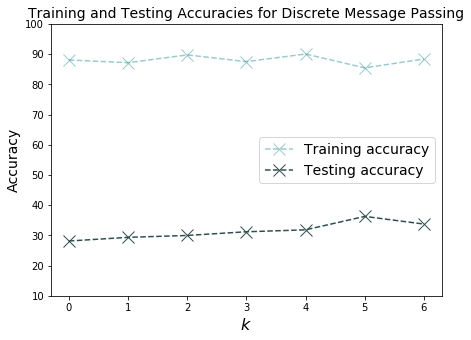

In [26]:
fig,ax = plt.subplots(1,figsize = (7,5))
ax.plot(ks,training_accuracies,'x--',color = 'teal',label = 'Training accuracy',markersize = 12,alpha = 0.4)
ax.plot(ks,testing_accuracies,'x--',color = 'darkslategrey',label = 'Testing accuracy',markersize = 12)
ax.set_title('Training and Testing Accuracies for Discrete Message Passing',fontsize = 14)
ax.set_xlabel(r'$k$',fontsize = 16)
ax.set_ylabel('Accuracy',fontsize = 14)
ax.legend(fontsize = 14,loc = 'center right')
ax.set_ylim((10,100))
fig.savefig(root_figures + '/Socioeconomic'+'/discrete_message_passing.pdf',dpi=fig.dpi,bbox_inches='tight')

In [27]:
print('Maximum testing accuracy obtained at k =',np.argmax(testing_accuracies),' is ', max(testing_accuracies))

Maximum testing accuracy obtained at k = 5  is  36.291637023289994


### Continuous Analogue of message passing

In [28]:
#define features to include
features = ['pop_density','gdp','employment','population','unemployment',
        'unemployment_rate']#'Level']

In [29]:
#define function to test accuracy for  argument t
def message_passing_t(t):

   
    # call the orginal dataframe
    df_complete = df_complete_c.copy()
    X = df_complete[features].values
    
    # Scaling #
    Xc =X.copy()
    scaler = StandardScaler()
    #fit scaler
    scaler.fit(Xc)
    #transform
    Xc=scaler.transform(Xc)
    X=pd.DataFrame(Xc)
    X.columns = features
    X = X.values
    
    # compute exponential e^{-tL}, where L is laplacian of adjacency
    laplacian = scipy.sparse.csgraph.laplacian(A)
    exp_laplacian = scipy.linalg.expm(-t*laplacian)
    
    # left multiply feature matrix by it
    newX = exp_laplacian.dot(X)
    
    # create new data frame with new X, to be compute classes_response again
    df_complete['pop_density'] = newX[:,0]
    df_complete['gdp'] = newX[:,1]
    df_complete['employment'] = newX[:,2]
    df_complete['population'] = newX[:,3]
    df_complete['unemployment'] = newX[:,4]
    df_complete['unemployment_rate'] = newX[:,5]
    #df_complete['Level'] = newX[:,6]
    df_complete['class_response'] = np.zeros(df_complete.shape[0])
    
    # threshold to divide into classes
    alpha_treshold = np.median(df_complete['alpha'])
    beta_treshold = np.median(df_complete['1_beta'])
    df_complete.loc[(df_complete['alpha']<=alpha_treshold) & (df_complete['1_beta']>beta_treshold), 'class_response'] = 0
    df_complete.loc[(df_complete['alpha']<=alpha_treshold) & (df_complete['1_beta']<=beta_treshold), 'class_response'] = 1
    df_complete.loc[(df_complete['alpha']>alpha_treshold) & (df_complete['1_beta']>beta_treshold), 'class_response'] = 2
    df_complete.loc[(df_complete['alpha']>alpha_treshold) & (df_complete['1_beta']<=beta_treshold), 'class_response'] = 3
    
    # new X and y
    X = df_complete[features]
    y = df_complete['class_response']
    
    # Scaling
    Xc =X.copy()
    scaler = StandardScaler()
    #fit scaler
    scaler.fit(Xc)
    #transform
    Xc=scaler.transform(Xc)
    X=pd.DataFrame(Xc)
    X.columns = features
    
    # take new X values
    newX = X.values
    
    # define number of folds, stratified cross validation splits
    N_FOLDS = 3
    skf = StratifiedKFold(n_splits=N_FOLDS,shuffle=True)
    skf.get_n_splits(newX, y)
    
    #create empty lists to then insert the folds
    X_train_all=[]
    X_test_all= []
    y_train_all=[]
    y_test_all=[]
    
    #loop to insert the data for each of the folds
    for train_index, test_index in skf.split(newX, y):
        
        X_train,X_test,y_train,y_test = prepare_train_test(train_index,test_index)
        
        X_train_all.append(X_train)
        X_test_all.append(X_test)
        y_train_all.append(y_train)
        y_test_all.append(y_test)
    
    # define model
    def build_model():
        
        #architecture
        model = Sequential()
        model.add(Dense(100, input_dim=len(features), activation='relu'))
        model.add(Dense(100, activation='relu'))
        model.add(Dense(100, activation='relu'))
        model.add(Dense(4, activation='softmax'))
        
        # compile the keras model
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model
    
    # initialize sums of training and testing accuracies
    acc_sum_train = 0
    acc_sum_test = 0
    
    # iterate for each of the folds
    for i in range(N_FOLDS):
        
        #call the model
        model = build_model()
        
        # fit the keras model on the dataset
        history = model.fit(X_train_all[i], y_train_all[i], epochs=50, batch_size=20,verbose =0)
        
        # evaluate the keras model
        _, accuracy_train = model.evaluate(X_train_all[i], y_train_all[i])
        _, accuracy_test = model.evaluate(X_test_all[i], y_test_all[i])
        
        # predict so that we can compute confussion matrix
        y_pred_training = model.predict(X_train_all[i])
        y_pred = model.predict(X_test_all[i])
        
        # transform predictions, which come in the form [p1,p2,p3,p4], where pi are probabilities,
        # into a single output using argmax
        y_pred_c = []
        y_pred_train_c = []
        for j in range(len(y_pred)):
            y_pred_c.append(np.argmax(y_pred[j]))
        for k in range(len(y_pred_training)):
            y_pred_train_c.append(np.argmax(y_pred_training[k]))
        y_pred = y_pred_c
        y_pred_training = y_pred_train_c
        
        # report accuracies
        print('Fold ',i)
        print('Training Accuracy = ',100*accuracy_score(y_train_all[i], y_pred_training))
        print('Testing Accuracy = ',100*accuracy_score(y_test_all[i], y_pred))
        
        # sum accuracies to total
        acc_sum_train += accuracy_train
        acc_sum_test += accuracy_test

    # average among number of folds
    training_accuracy = 100*(acc_sum_train/N_FOLDS)
    testing_accuracy = 100*(acc_sum_test/N_FOLDS)
    
    # report cross-validation accuracies
    print('-------------------------------------------------------------')
    print('Average Training Accuracy:' ,100*(acc_sum_train/N_FOLDS))
    print('Average Testing Accuracy:' ,100*(acc_sum_test/N_FOLDS))
    
    
    return training_accuracy, testing_accuracy
    


In [30]:
%%capture
times = [10**(-3),10**(-2),10**(-1),10**(0),10**(1),10**(2),10**3]
training_accuracies = []
testing_accuracies = []
for t in times:
    training_accuracy, testing_accuracy = message_passing_t(t)
    training_accuracies.append(training_accuracy)
    testing_accuracies.append(testing_accuracy)

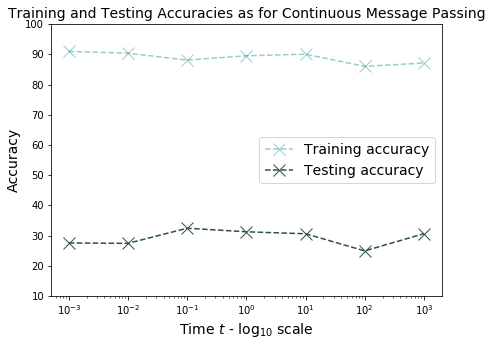

In [31]:
fig,ax = plt.subplots(1,figsize = (7,5))
ax.plot(times,training_accuracies,'x--',color = 'teal',label = 'Training accuracy',markersize = 12,alpha =0.4)
ax.plot(times,testing_accuracies,'x--',color = 'darkslategrey',label = 'Testing accuracy',markersize = 12)
ax.set_title('Training and Testing Accuracies as for Continuous Message Passing',fontsize = 14)
ax.set_xlabel(r'Time $t$ - $\log_{10}$ scale',fontsize = 14)
ax.set_ylabel('Accuracy',fontsize = 14)
ax.legend(fontsize = 14,loc ='center right')
ax.set_xscale('log')
ax.set_ylim((10,100))
fig.savefig(root_figures + '/Socioeconomic'+'/continuous_message_passing.pdf',dpi=fig.dpi,bbox_inches='tight')

In [32]:
print('Maximum testing accuracy obtained at t =',np.argmax(testing_accuracies),' is ', max(testing_accuracies))

Maximum testing accuracy obtained at t = 2  is  32.448170582453415


# GCN with SPEKTRAL

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from spektral.data.loaders import SingleLoader
from spektral.datasets.citation import Citation
from spektral.layers import GCNConv
from spektral.models.gcn import GCN
from spektral.transforms import AdjToSpTensor, LayerPreprocess
from spektral.data import BatchLoader
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from spektral.layers import GCNConv, GlobalSumPool
from spektral.datasets import Cora
from spektral.datasets import TUDataset
from spektral.datasets import citation
from spektral.data import Dataset
from spektral.data import Graph
import spektral
from spektral.datasets.citation import Citation

#### Import graph 

In [34]:
#import graph
root_graph = root_results+'/NUTS3_Graph'+'/NUTS3_base_network_lscc.npz'
with open(root_graph, 'rb') as handle:
        G = pickle.load(handle)

#check which nodes are in df_complete
nodes_in_df = list(df_complete_c['nuts_no'])
G_nodes = list(G.nodes)
G_nodes_to_remove = [i for i in G_nodes if i not in nodes_in_df]

for i in range(len(G_nodes_to_remove)):
    G.remove_node(G_nodes_to_remove[i])

print('The graph has',len(G),'nodes')

The graph has 160 nodes


#### Prepare Data X and Y 

In [35]:
# call the original df_complete
df_complete = df_complete_c.copy()
df_complete['class_response'] = np.zeros(df_complete.shape[0])

# thresholds and divisions into classes
alpha_treshold = np.median(df_complete['alpha'])
beta_treshold = np.median(df_complete['1_beta'])
df_complete.loc[(df_complete['alpha']<=alpha_treshold) & (df_complete['1_beta']>beta_treshold), 'class_response'] = 0
df_complete.loc[(df_complete['alpha']<=alpha_treshold) & (df_complete['1_beta']<=beta_treshold), 'class_response'] = 1
df_complete.loc[(df_complete['alpha']>alpha_treshold) & (df_complete['1_beta']>beta_treshold), 'class_response'] = 2
df_complete.loc[(df_complete['alpha']>alpha_treshold) & (df_complete['1_beta']<=beta_treshold), 'class_response'] = 3

# define features
features = ['pop_density','gdp','employment','population','unemployment',
            'unemployment_rate']#'Level']

# define feature matrix X and response y
X = df_complete[features]
y = df_complete['class_response']

# scaling X
Xc =X.copy()
scaler = StandardScaler()
#fit scaler
scaler.fit(Xc)
#transform
Xc=scaler.transform(Xc)
X=pd.DataFrame(Xc)
X.columns = features

In [36]:
# compute adjacency matrix
A = nx.adjacency_matrix(G)

# convert X and y to arrays so that they are 'readable' by MyDataset()
X = np.array(X)
y = np.array(y)

# Compute adjacency matrix
A = nx.adjacency_matrix(G)

want_A_bool = False
want_A_normalized = True


if want_A_bool == True:
    
    # compute boolean form of adjacency matrix matrix i.e. just ones and zeros
    A= np.array(A.todense())
    A_bool = A.copy()
    A_bool = A_bool >0
    A_bool = 1*A_bool
    A = A_bool
    
if want_A_normalized == True: 
    
    # standardize adjacency matrix
    A = spektral.utils.normalized_adjacency(A, symmetric=True)

A = A.todense()

In [37]:
# create datafram with y
y_df = pd.DataFrame({'c' : y})
y_df = pd.get_dummies(y_df,columns= ['c'])
y_df = y_df.rename(columns={"c_0.0": "0", "c_1.0": "1","c_2.0": "2", "c_3.0": "3"})

## Define Dataset Builder

In [38]:
class MyDataset(Dataset):
    """
    function that builds the dataset
    """
    def __init__(self, X, A,y, **kwargs):
        self.X = X
        self.A = A
        self.y = y

        super().__init__(**kwargs)
        
    def read(self):
        # We must return a list of Graph objects
        output = []
        x = self.X
        a = self.A
        y = self.y

        #filename = '/Users/ignaciosacristanbarba/Documents/M4R/TRY GCN'+'/mygraph.npz'
        filename = os.path.join(self.path, 'graph.npz')
        np.savez(filename, x=x, a=a, y=y)
        
        #data = np.load('/Users/ignaciosacristanbarba/Documents/M4R/TRY GCN'+ '/mygraph.npz')
        data = np.load(os.path.join(self.path, 'graph.npz'))
        #print(data['a'])
        output.append(Graph(x=data['x'], a=data['a'], y=data['y']))

        return output

In [39]:
dataset = MyDataset(X,A,y_df)

### with train-test

# GCN With Cross Validation

In [40]:
# call the function MyDataset to create dataset with the three components:
# Feature matrix, adjacency matrix and response
dataset = MyDataset(X,A,y_df)

In [41]:
def train_test_GCN_CV():   
    '''
    Function to train and test a GCN with cross validation
    '''
    # choose hyperparameters 
    learning_rate = 1e-2
    patience = 10
    epochs = 500
    
    # choose number of folds and call stratified CV
    N_FOLDS = 3
    skf = StratifiedKFold(n_splits=N_FOLDS,shuffle=True)
    
    # create the cross-validation boolean masks (i.e. True/False)
    # to truncate data into CV train and test
    masks = []
    for train_index,test_index in skf.split(X,y):
        mask = np.array([True for i in range(len(y))])
    for i,ix in enumerate(test_index):
        mask[ix] = False
        masks.append(mask)
    
    # initialize list of ALL non-aggregated accuracies,
    accs_in_GCN = []
    
    #initialize CV accuracies and confussion matrix
    accuracy_test_tot = 0
    gcn_test_confusion_matrix = np.zeros((4,4))
    
    # loop for all loops
    for i in range(N_FOLDS):
        
        # choose the mask and apply it to the response
        msk = masks[i]
        y_train = y[msk]  
        y_test = y[~msk]  # inverse of boolean mask

        # Define the model
        model = GCN(n_labels=dataset.n_labels, n_input_channels=dataset.n_node_features)
        
        # compile
        model.compile(
            optimizer=Adam(learning_rate),
            loss=CategoricalCrossentropy(reduction="sum"),
            weighted_metrics=["acc"],
        )
        
        # define training loader
        loader_tr = SingleLoader(dataset)
        loader_tr = SingleLoader(dataset,sample_weights=msk)
        loader_test = SingleLoader(dataset,sample_weights=~msk)

        # fit model
        model.fit(
            loader_tr.load(),
            steps_per_epoch=loader_tr.steps_per_epoch,
            epochs=epochs,
            shuffle = True,
            verbose=0 
            #class_weight = class_weights,
        )
        
        # predict on test data using fitted model
        y_pred_a = model.predict(loader_test.load(),steps=loader_test.steps_per_epoch)
        y_pred_a = np.array(y_pred_a[~msk]) # note use of inverse boolean mask to get the predicted only
        
        # transform predictions, which come in the form [p1,p2,p3,p4], where pi are probabilities,
        # into a single output using argmax
        y_pred_no = []
        for i in range(y_pred_a.shape[0]):
            y_pred_no.append(np.argmax(y_pred_a[i]))
            
        # compute accuracy
        accuracy_test = accuracy_score(y_test,y_pred_no)
        
        # sum the confusion matrix and accuracy score
        gcn_test_confusion_matrix += confusion_matrix(y_test,y_pred_no)
        accuracy_test_tot += accuracy_test
        # append accuracy to list ALL non-aggregated acuracies
        accs_in_GCN.append(accuracy_test)    
        
    # report cross validation accuracy
    print('Accuracy is',accuracy_score(y_test,y_pred_no))
    
    # save cross-validated accuracy and confusion matrix
    accuracy_test = accuracy_test_tot/N_FOLDS
    gcn_test_confusion_matrix = gcn_test_confusion_matrix/N_FOLDS
    
    return accuracy_test,gcn_test_confusion_matrix,accs_in_GCN




### Run 30 times and average

In [42]:
#%%capture
# run the procedure n times
n = 30

# initialize accuracy and confussion matrix
total_ac = 0
total_cm = np.zeros((4,4))
accs_GCN = [] #list of ALL non aggregated accuracies, for histogram later

# loop n times
for i in range(n):
    
    # call the procedure 
    ac,cm,accs_in_GCN = train_test_GCN_CV()
    
    # store results
    accs_GCN.append(accs_in_GCN)
    total_ac+= ac
    total_cm += cm
    
# average results over the n iterations
gcn_ac = total_ac/n 
gcn_conf_mat = total_cm/n

Accuracy is 0.2830188679245283
Accuracy is 0.2830188679245283
Accuracy is 0.39622641509433965
Accuracy is 0.3018867924528302


Accuracy is 0.33962264150943394
Accuracy is 0.33962264150943394
Accuracy is 0.37735849056603776


Accuracy is 0.3018867924528302
Accuracy is 0.3018867924528302
Accuracy is 0.32075471698113206
Accuracy is 0.41509433962264153


Accuracy is 0.37735849056603776
Accuracy is 0.41509433962264153
Accuracy is 0.24528301886792453
Accuracy is 0.3584905660377358


Accuracy is 0.33962264150943394
Accuracy is 0.39622641509433965
Accuracy is 0.2830188679245283


Accuracy is 0.41509433962264153
Accuracy is 0.33962264150943394
Accuracy is 0.33962264150943394
Accuracy is 0.2830188679245283


Accuracy is 0.32075471698113206
Accuracy is 0.33962264150943394
Accuracy is 0.39622641509433965
Accuracy is 0.2641509433962264


Accuracy is 0.4339622641509434
Accuracy is 0.37735849056603776
Accuracy is 0.22641509433962265


Accuracy is 0.37735849056603776


GCN accuracy is 0.3371069182389938
0.33710691823899375


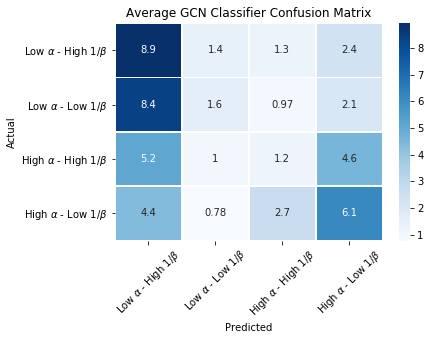

In [43]:
# report average accuracy and plot confussion matrix

print('GCN accuracy is',gcn_ac)
gcn_cm = pd.DataFrame(gcn_conf_mat, index = [r"Low $\alpha$ - High 1/$\beta$", r"Low $\alpha$ - Low 1/$\beta$", r"High $\alpha$ - High 1/$\beta$",r'High $\alpha$ - Low 1/$\beta$'],
          columns = [r"Low $\alpha$ - High 1/$\beta$",r"Low $\alpha$ - Low 1/$\beta$", r"High $\alpha$ - High 1/$\beta$",r'High $\alpha$ - Low 1/$\beta$'])
fig,axs = plt.subplots(ncols=1)
s = sns.heatmap(gcn_cm, annot=True,cmap="Blues" ,linewidths=0.5,ax=axs)
s.set_xticklabels(s.get_xticklabels(), rotation = 45, fontsize = 10)
axs.set_xlabel('Predicted')
axs.set_ylabel('Actual')
axs.set_title('Average GCN Classifier Confusion Matrix')
fig.savefig(root_figures + '/Socioeconomic'+'/GCN_confusion.pdf',dpi=fig.dpi,bbox_inches='tight')

print(sum(np.diag(gcn_conf_mat))/np.sum(np.matrix(gcn_conf_mat)))


In [44]:
# flatten list of lists of accuracies to can plot histogram
accs_GCN = [j for i in accs_GCN for j in i]

#Multiply list by 100 to get percentage accuracies
accs_GCN = [100*x for x in accs_GCN]

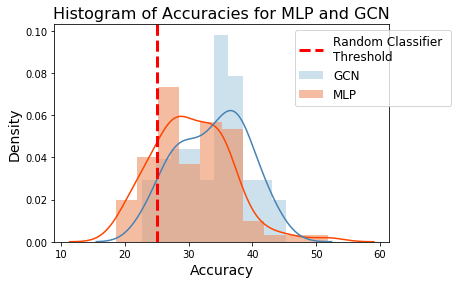

In [45]:
# plot both histograms 

fig,ax = plt.subplots(1)

plt.hist(accs_GCN,bins = 10,color = '#adcde2',label = 'GCN',alpha = 0.6,density = True)
plt.hist(accs_MLP,bins = 10,color = '#ee9164',label = 'MLP',alpha = 0.6,density = True)

# plot density curves
sns.distplot(accs_MLP,kde = True,color = 'orangered',hist = False,bins = 10)
sns.distplot(accs_GCN,kde = True,color = 'steelblue',hist = False,bins = 10)
            
ax.set_title('Histogram of Accuracies for MLP and GCN',fontsize = 16)
ax.set_xlabel(r'Accuracy',fontsize = 14)
ax.set_ylabel('Density',fontsize = 14)
ax.axvline(25,label='Random Classifier \nThreshold',color = 'red',linestyle='dashed',linewidth=3)

ax.legend(fontsize = 12,loc='upper left',bbox_to_anchor=(0.7, 1))

fig.savefig(root_figures + '/Socioeconomic'+'/randomness_histograms.pdf',bbox_inches='tight')

In [46]:
# compute mean and standard deviations of accuracies
print('Mean for MLP =',np.mean(accs_MLP))
print('Mean for GCN =',np.mean(accs_GCN))

print('Standard Deviation for MLP =',np.std(accs_MLP))
print('Standard Deviation for GCN =',np.std(accs_GCN))

Mean for MLP = 30.457333591249252
Mean for GCN = 33.710691823899374
Standard Deviation for MLP = 6.015323305096897
Standard Deviation for GCN = 5.505929214651394


#### Re-plot MLP results with colormap cap

The BASELINE Accuracy is 30.457333591249252


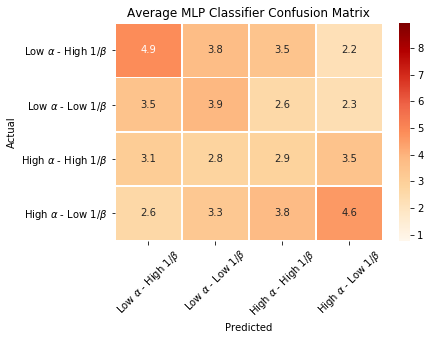

In [47]:
# Report baseline accuracy  
print('The BASELINE Accuracy is',baseline_ac)

# Plot average MLP confussion matrix
mlp_cm = pd.DataFrame(baseline_cm, index = [r"Low $\alpha$ - High 1/$\beta$", r"Low $\alpha$ - Low 1/$\beta$", r"High $\alpha$ - High 1/$\beta$",r'High $\alpha$ - Low 1/$\beta$'],
                      columns = [r"Low $\alpha$ - High 1/$\beta$",r"Low $\alpha$ - Low 1/$\beta$", r"High $\alpha$ - High 1/$\beta$",r'High $\alpha$ - Low 1/$\beta$'])
fig,axs = plt.subplots(ncols=1)
vmax = np.max(gcn_cm.values)
vmin = np.min(gcn_cm.values)

s = sns.heatmap(mlp_cm, annot=True,cmap="OrRd" ,linewidths=0.5,ax=axs,vmax =vmax,vmin =vmin)
s.set_xticklabels(s.get_xticklabels(), rotation = 45, fontsize = 10)
axs.set_xlabel('Predicted')
axs.set_ylabel('Actual')
axs.set_title('Average MLP Classifier Confusion Matrix')
fig.savefig(root_figures + '/Socioeconomic'+'/MLP_confusion.pdf',dpi=fig.dpi,bbox_inches='tight')